In [37]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings


warnings.filterwarnings('ignore')

competitions = pd.read_csv('/Users/rohanshah/Desktop/DATATHON2024/competitions.csv')
appearances = pd.read_csv('/Users/rohanshah/Desktop/DATATHON2024/appearances.csv')
club_games = pd.read_csv("/Users/rohanshah/Desktop/DATATHON2024/club_games.csv")
clubs = pd.read_csv('/Users/rohanshah/Desktop/DATATHON2024/clubs.csv')
game_events = pd.read_csv('/Users/rohanshah/Desktop/DATATHON2024/game_events.csv')
game_lineups = pd.read_csv('/Users/rohanshah/Desktop/DATATHON2024/game_lineups.csv')
games = pd.read_csv('/Users/rohanshah/Desktop/DATATHON2024/games.csv')
players = pd.read_csv('/Users/rohanshah/Desktop/DATATHON2024/players.csv')
player_values = pd.read_csv('/Users/rohanshah/Desktop/DATATHON2024/player_valuations.csv')


game = games
club = clubs
player_value = player_values
appearance = appearances

In [38]:
club_name = "Chelsea" 
season = 2023 

#Club ID
clubs = clubs[clubs['name'].str.contains(club_name, case=False)]
club_id = clubs[clubs['name'].str.contains(club_name, case=False)]['club_id'].iat[0]

#Their Domestic League ID 
league_id = clubs['domestic_competition_id'].iat[0]

#Get the country of the club
club_country = competitions[competitions['competition_id'] == league_id]['country_name'].iat[0]

print(f"Club ID: {club_id}")
print(f"League ID: {league_id}")
print(f"Country: {club_country}")

Club ID: 631
League ID: GB1
Country: England


In [39]:
appearances['date'] = pd.to_datetime(appearances['date'])
appearances['season'] = appearances['date'].apply(lambda x: f'{x.year}-{x.year + 1}' if x.month >= 8 else f'{x.year - 1}-{x.year}')
appearances['season_start_year'] = appearances['season'].str.split('-').str[0].astype(int)
appearances['season_end_year'] = appearances['season'].str.split('-').str[1].astype(int)
appearances['season_start_month_year'] = appearances['season_start_year'].apply(lambda x: f"08 {x}")

print(appearances[['player_id', 'player_club_id', 'player_name', 'season', 'season_start_year', 'season_end_year']].head())

   player_id  player_club_id       player_name     season  season_start_year   
0      38004             853  Aurélien Joachim  2011-2012               2011  \
1      79232            8841    Ruslan Abyshov  2011-2012               2011   
2      42792            6251       Sander Puri  2011-2012               2011   
3      73333            1274   Vegar Hedenstad  2011-2012               2011   
4     122011             195  Markus Henriksen  2011-2012               2011   

   season_end_year  
0             2012  
1             2012  
2             2012  
3             2012  
4             2012  


In [40]:
#Get all domestic games in that season
games['date'] = pd.to_datetime(games['date'])
games = games[((games['home_club_id'] == club_id) | (games['away_club_id'] == club_id)) & (games['season'] == season)]
games_id = games[games['competition_id'] == league_id].sort_values(by='round')['game_id'].tolist()
domestic_game = games[games['competition_id'] == league_id].sort_values(by='date')

#Create an extra column which calculates the number of goals in a match
club_games = club_games[((club_games['club_id'] == club_id)) & (club_games['game_id'].isin(games_id))]
club_games['total_goals'] = club_games['own_goals'] + club_games['opponent_goals']
club_games['clean_sheets'] = club_games.apply(
    lambda row: 1 if (row['opponent_id'] == 148 and row['own_goals'] == 0) | (row['club_id'] == 148 and row['opponent_goals'] == 0) else 0,
    axis=1
)

game_events = game_events[(game_events['club_id'] == club_id ) & (game_events['game_id'].isin(games_id))]
game_lineups = game_lineups[(game_lineups['club_id'] == club_id ) & (game_lineups['game_id'].isin(games_id))]


In [41]:
appearances = appearances[appearances['player_club_id'] == club_id]
appearances = appearances[(appearances['game_id'].isin(games_id)) & (appearances['player_club_id'] == club_id)]
get_all_players = set(appearances['player_id'].to_list())

#Make an categorical order for the positions
order = ['Goalkeeper', 'Defender', 'Midfield', 'Attack']
players['position'] = pd.Categorical(players['position'], categories=order, ordered=True)
players['date_of_birth'] = pd.to_datetime(players['date_of_birth'])
players['is_foreigner'] = np.where(players['country_of_citizenship'] != club_country, 1, 0)
players['age'] = season - players['date_of_birth'].dt.year

player_values['date'] = pd.to_datetime(player_values['date'])
player_values['month_year'] = player_values['date'].apply(lambda x: f"08 {x.year}" if x >= pd.Timestamp(x.year, 7, 1) else f"08 {x.year-1}")
player_values['season'] = player_values['date'].apply(lambda x: f"{x.year}-{x.year+1}" if x >= pd.Timestamp(x.year, 7, 1) else f"{x.year-1}-{x.year}")
player_values = player_values.loc[player_values.groupby(['player_id','season'])['date'].idxmin()] #Get value only at start of season

players_current_season = players[players['player_id'].isin(get_all_players)]
players_current_season['season_start'] = f'08 {season}'

#Get the value of the following season
players_current_season = players_current_season.merge(player_values[['player_id', 'market_value_in_eur', 'month_year']], 
                left_on=['season_start', 'player_id'], right_on=['month_year', 'player_id'])
attribute = ['name', 'country_of_citizenship', 'date_of_birth', 'sub_position', 'foot', 'height_in_cm', 'market_value_in_eur_y'] #Attribute for the display the players

print(players.dtypes)


player_id                                        int64
first_name                                      object
last_name                                       object
name                                            object
last_season                                      int64
current_club_id                                  int64
player_code                                     object
country_of_birth                                object
city_of_birth                                   object
country_of_citizenship                          object
date_of_birth                           datetime64[ns]
sub_position                                    object
position                                      category
foot                                            object
height_in_cm                                   float64
contract_expiration_date                        object
agent_name                                      object
image_url                                       object
url       

In [42]:
'''Name, Stadium and attendance'''
name = clubs['name'].iat[0]
stadium = clubs['stadium_name'].iat[0]
attendance = clubs['stadium_seats'].iat[0]
print(f'{name} plays in {stadium} with {attendance} seats\n')

'''Club link on transfermarkt'''
url = clubs[clubs['name'].str.contains(club_name)]['url'].iat[0]
print(f"Club URL on Transfermarkt: {url}\n")

'''Coach'''
a = set(club_games[club_games['club_id'] == club_id]['own_manager_name'].tolist())
b = set(club_games[club_games['opponent_id'] == club_id]['opponent_manager_name'].tolist())
coach = list(set(a|b))
if len(coach) == 1:
    coach = coach[0]
print(f'Manager in {season}/{season+1} season is {coach}\n')

'''Total market value'''
total_market_value = players_current_season['market_value_in_eur_y'].sum()
print(f'In {season}/{season+1} the club has a total market value of {total_market_value}€\n')

'''Most valuable player'''
mvp = players_current_season[attribute][players_current_season['market_value_in_eur_y'] == players_current_season['market_value_in_eur_y'].max()]
print(f"Most valuable player of the team:\n{mvp}\n")

'''Average Age, oldest, youngest players'''
avg_age = players_current_season['age'].mean()
print(f'Average age of the team is {round(avg_age, 2)} years old\n')

oldest = players_current_season[['name', 'age']][players_current_season['age'] == players_current_season['age'].max()]
youngest = players_current_season[['name', 'age']][players_current_season['age'] == players_current_season['age'].min()]
print(f"The youngest player of the team are:\n {youngest}\n")
print(f"The oldest player of the team are:\n {oldest}")

'''most played'''
most_minutes = appearances.groupby('player_name')['minutes_played'].sum().sort_values(ascending=False).head(1)
print(f"\nPlayer with the most minutes\n {most_minutes}")

Chelsea Football Club plays in Stamford Bridge with 40853 seats

Club URL on Transfermarkt: https://www.transfermarkt.co.uk/fc-chelsea/startseite/verein/631

Manager in 2023/2024 season is Mauricio Pochettino

In 2023/2024 the club has a total market value of 0€

Most valuable player of the team:
Empty DataFrame
Columns: [name, country_of_citizenship, date_of_birth, sub_position, foot, height_in_cm, market_value_in_eur_y]
Index: []



TypeError: 'list' object is not callable

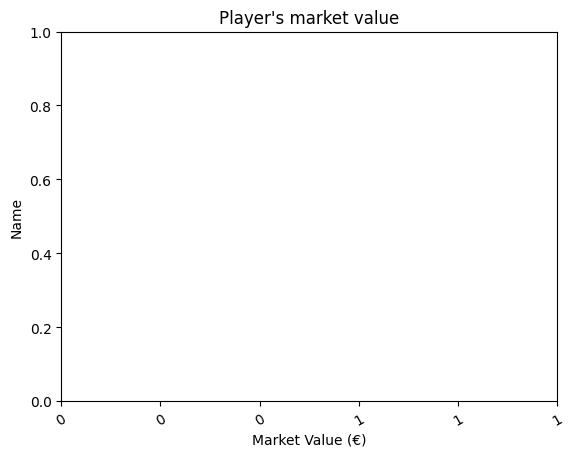


The most used XI of the season:
 Empty DataFrame
Columns: [name, country_of_citizenship, date_of_birth, sub_position, foot, height_in_cm, market_value_in_eur_y]
Index: [] 



In [ ]:
sns.barplot(data=players_current_season.sort_values(by='market_value_in_eur_y', ascending=False), x='market_value_in_eur_y', y='name', edgecolor="none")
def format_func(value, tick_number):
    return f'{value:.0f}'

pvl = plt.gca()
pvl.xaxis.set_major_formatter(ticker.FuncFormatter(format_func)) #This change to full display of number in x-axis

plt.xlabel('Market Value (€)')
plt.xticks(rotation=30)

plt.ylabel('Name')
plt.title("Player's market value")
plt.show()

#XI
xi_id = appearances[(appearances['game_id'].isin(games_id))].groupby('player_id')['minutes_played'].sum(). \
        sort_values(ascending = False).index[:11].tolist()
xi = players_current_season[players_current_season['player_id'].isin(xi_id)].sort_values(by='position')[attribute]

print(f"\nThe most used XI of the season:\n {xi} \n")

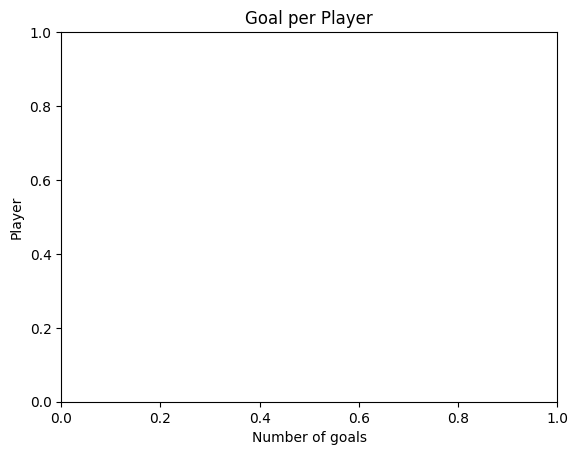

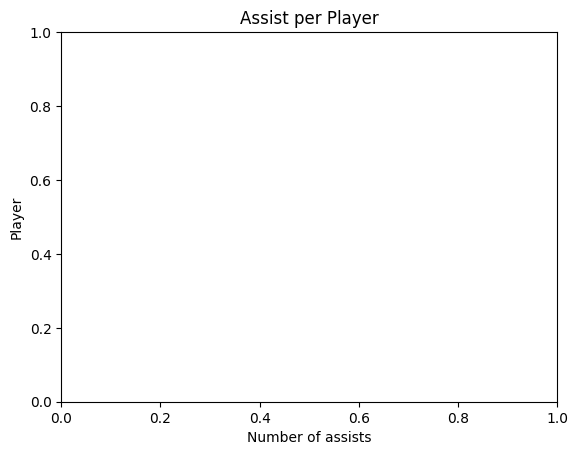

In [ ]:
#Goals per Player
goal_assist = appearances.groupby('player_name')[['goals', 'assists']].sum()
goal = goal_assist[goal_assist['goals'] > 0].sort_values(by='goals', ascending = False).reset_index()
sns.barplot(data=goal, y='player_name', x='goals')
plt.title('Goal per Player')
plt.xlabel('Number of goals')
plt.ylabel('Player')
plt.show()

#Assists per Player
assist = goal_assist[goal_assist['assists'] > 0].sort_values(by='assists', ascending = False).reset_index()
sns.barplot(data=assist, y='player_name', x='assists')
plt.title('Assist per Player')
plt.xlabel('Number of assists')
plt.ylabel('Player')
plt.show()

In [ ]:
goal_assist['total_contribution'] = goal_assist['goals'] + goal_assist['assists']
goal_assist.reset_index(inplace=True)
player_most_contribution = (goal_assist[goal_assist['total_contribution'] == goal_assist['total_contribution'].max()] \
                            [['player_name', 'total_contribution']].values.tolist())
player_most_contribution_list = [player[0] for player in player_most_contribution]

print(f"Player with the most goal contribution:")
for i in range(0, len(player_most_contribution)):
    print(f"{i+1}. {player_most_contribution[i][0]} with {player_most_contribution[i][1]} goals and assists")

Player with the most goal contribution:


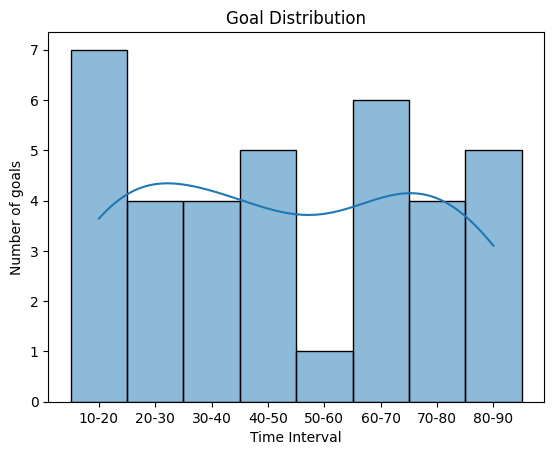

In [ ]:
bins = list(range(0, 101, 10))
label = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-']
game_events['interval'] = pd.cut(game_events['minute'], bins=bins, labels=label)
total_goals = club_games['own_goals'].sum()
goals = game_events[(game_events['type'] == 'Goals') & (game_events['club_id'] == club_id)]

sns.histplot(data=goals, x='interval', kde=True)
plt.title('Goal Distribution')
plt.ylabel('Number of goals')
plt.xlabel('Time Interval')

plt.show()

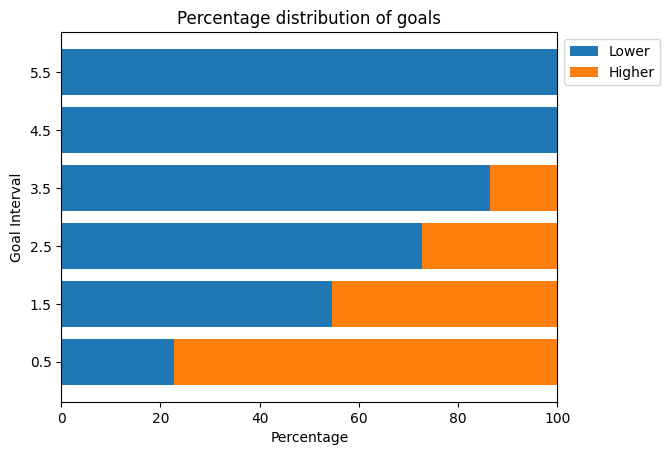

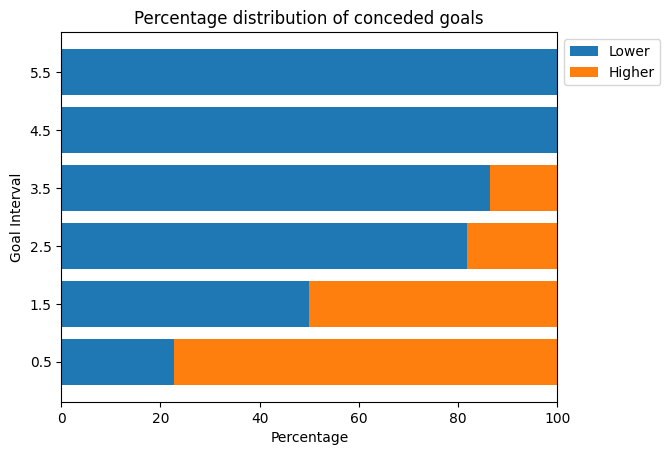

In [ ]:
goal_col = club_games['own_goals']
bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
bin_labels = ['0.5', '1.5', '2.5', '3.5', '4.5', '5.5']

# Calculate percentage distribution of total goals
lower = [np.sum(goal_col < bin) / len(goal_col) * 100 for bin in bins]
higher = [np.sum(goal_col > bin) / len(goal_col) * 100 for bin in bins]

fig, plot_percentage = plt.subplots()
plot_percentage.barh(bin_labels, lower, label='Lower')
plot_percentage.barh(bin_labels, higher, left=lower, label='Higher')

plot_percentage.set_xlabel('Percentage')
plot_percentage.set_ylabel('Goal Interval')
plot_percentage.set_title('Percentage distribution of goals')
plot_percentage.legend(bbox_to_anchor=(1, 1), loc='upper left')

#Conceded Goals
conceed_col = club_games['opponent_goals']
lower = [np.sum(conceed_col < bin) / len(goal_col) * 100 for bin in bins]
higher = [np.sum(conceed_col > bin) / len(goal_col) * 100 for bin in bins]

figu, plot_percentages = plt.subplots()
plot_percentages.barh(bin_labels, lower, label='Lower')
plot_percentages.barh(bin_labels, higher, left=lower, label='Higher')

plot_percentages.set_xlabel('Percentage')
plot_percentages.set_ylabel('Goal Interval')
plot_percentages.set_title('Percentage distribution of conceded goals')
plot_percentages.legend(bbox_to_anchor=(1, 1), loc='upper left')



Chelsea has a foreign rate of nan%



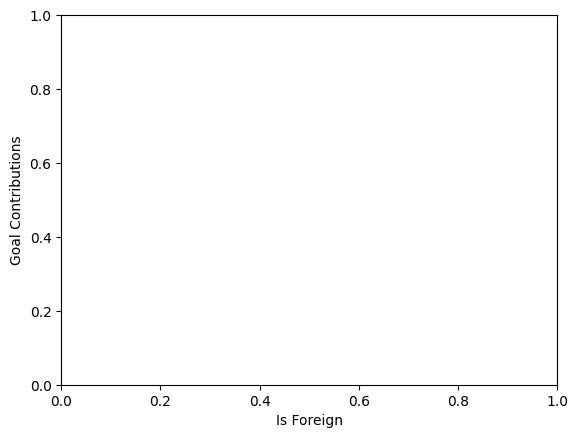

In [ ]:
foreign_rate = players_current_season[players_current_season['is_foreigner'] == 1]['is_foreigner'].sum()/ len(players_current_season) * 100
print(f'\n{club_name} has a foreign rate of {round(foreign_rate,2)}%\n')

'''box plot of foreign players with goal contributions'''
player_contribution = players_current_season.merge(goal_assist, left_on='name', right_on='player_name', how='left')
player_contribution['total_contribution'].fillna(0, inplace=True)

sns.boxplot(data=player_contribution, x='is_foreigner', y='total_contribution')
plt.xlabel('Is Foreign')
plt.ylabel('Goal Contributions')

plt.show()

In [ ]:
results = {'win': 0, 'draw': 0, 'lose': 0}

# Check for wins, draws, and losses
for index, row in domestic_game.iterrows():
    if row['home_club_id'] == club_id:
        if row['home_club_goals'] > row['away_club_goals']:
            results['win'] += 1
        elif row['home_club_goals'] == row['away_club_goals']:
            results['draw'] += 1
        else:
            results['lose'] += 1
    elif row['away_club_id'] == club_id:
        if row['away_club_goals'] > row['home_club_goals']:
            results['win'] += 1
        elif row['away_club_goals'] == row['home_club_goals']:
            results['draw'] += 1
        else:
            results['lose'] += 1
print(f"Results in the season: {results}")

'''Home, Away results'''
home = {'win': 0, 'draw': 0, 'lose': 0}
for index, row in domestic_game.iterrows():
    if row['home_club_id'] == club_id:
        if row['home_club_goals'] > row['away_club_goals']:
            home['win'] += 1
        elif row['home_club_goals'] == row['away_club_goals']:
            home['draw'] += 1
        else:
            home['lose'] += 1
print(f"\nResults when playing at home: {home}")

away = {'win': 0, 'draw': 0, 'lose': 0}
for index, row in domestic_game.iterrows():
    if row['away_club_id'] == club_id:
        if row['away_club_goals'] > row['home_club_goals']:
            away['win'] += 1
        elif row['away_club_goals'] == row['home_club_goals']:
            away['draw'] += 1
        else:
            away['lose'] += 1
print(f"\nResults when playing away from home: {away}")

#Points per game
points_per_game = (results['win'] * 3 + results['draw']) / (results['win'] + results['draw'] + results['lose'])
print(f"\nAfter {results['win'] + results['draw'] + results['lose']} matches the team gets an average of {round(points_per_game, 2)} points per game")

#Clean sheets
clean_sheets = club_games['clean_sheets'].sum()
print(f'\nThe club has {clean_sheets} matches where they conceeded no goal ({round(clean_sheets/len(club_games) * 100, 2)}%)')


Results in the season: {'win': 9, 'draw': 4, 'lose': 9}

Results when playing at home: {'win': 5, 'draw': 3, 'lose': 3}

Results when playing away from home: {'win': 4, 'draw': 1, 'lose': 6}

After 22 matches the team gets an average of 1.41 points per game

The club has 0 matches where they conceeded no goal (0.0%)


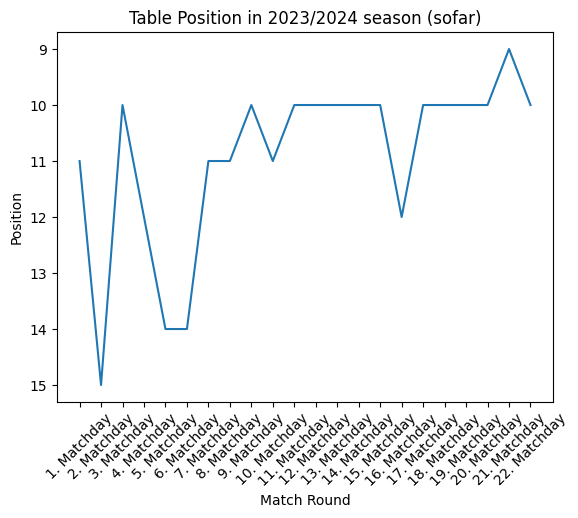

In [ ]:
position = []
round = []
for index, row in domestic_game[['round','home_club_id', 'away_club_id', 'home_club_position', 'away_club_position']].iterrows():
    round.append(row['round'])
    if row['home_club_id'] == club_id:
        position.append(row['home_club_position'])
    elif row['away_club_id'] == club_id:
        position.append(row['away_club_position'])
        
plt.plot(round, position)
plt.gca().invert_yaxis()
plt.title(f'Table Position in {season}/{season+1} season (sofar)')

plt.xlabel('Match Round')
plt.xticks(rotation=45)

plt.ylabel('Position')
plt.show()

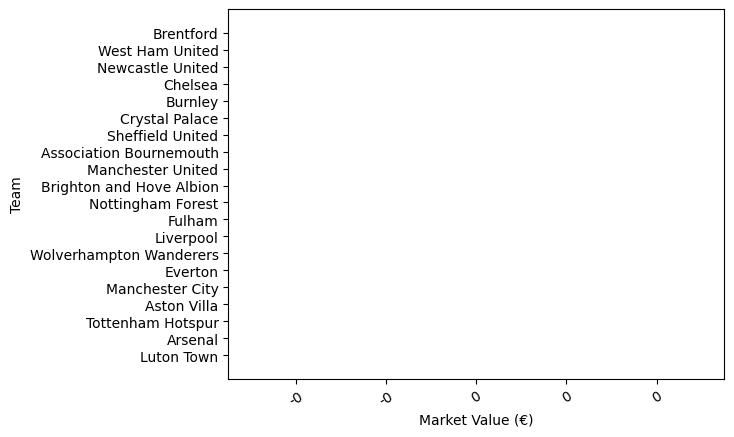

In [43]:
clubs_id = set(game[(game['competition_id'] == league_id) & (game['season'] == season)]['home_club_id'].tolist())
team_name = []
market_value = []

for id in clubs_id: #It displays the full market value for all team in that season
    team_name.append(club[club['club_id'] == id]['name'].iat[0])
    
    game_team = game[((game['home_club_id'] == id) | (game['away_club_id'] == id)) & (game['season'] == season)]
    gameid = game_team[game_team['competition_id'] == league_id].sort_values(by='round')['game_id'].tolist()
    app = appearance[(appearance['game_id'].isin(gameid)) & (appearance['player_club_id'] == id)]
    get_all = set(app['player_id'].to_list())
    players_current = players[players['player_id'].isin(get_all)]
    players_current['season_start'] = f'08 {season}'
    players_current = players_current.merge(player_value[['player_id', 'market_value_in_eur', 'month_year']], 
                    left_on=['season_start', 'player_id'], right_on=['month_year', 'player_id'])
    players_current.drop_duplicates(subset=['player_id'], inplace=True)
    
    market_value.append(players_current['market_value_in_eur_y'].sum())

team_name = [name.replace(" Football Club", "") for name in team_name] #Shorten the name but only applied for English club

#pair sort the team and their values
team_and_market_value = list(zip(team_name, market_value))
team_and_market_value.sort(key=lambda x: x[1])
team_name, market_value = zip(*team_and_market_value)

plt.barh(team_name, market_value)
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_func))

plt.xlabel('Market Value (€)')
plt.xticks(rotation=30)

plt.ylabel('Team')
plt.show()

   season         round       date                  home_club_name aggregate   
0    2023   6. Matchday 2023-09-24           Chelsea Football Club       0:1  \
1    2023  13. Matchday 2023-11-25  Newcastle United Football Club       4:1   
2    2023  14. Matchday 2023-12-03           Chelsea Football Club       3:2   

                           away_club_name  Number of cards  
0               Aston Villa Football Club                1  
1                   Chelsea Football Club                1  
2  Brighton and Hove Albion Football Club                1  


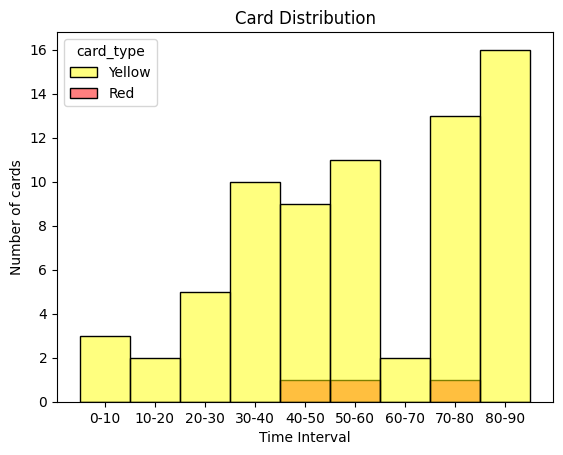

In [ ]:
cards = game_events[(game_events['type'] == 'Cards') & (game_events['club_id'] == club_id)]
conditions = [(cards['description'].str.contains('Yellow card', case=False)), (cards['description'].str.contains('Red|Second yellow', case=False))]
choice = ['Yellow', 'Red']
cards['card_type'] = np.select(conditions, choice)

game_id_red_card = cards[cards['description'].str.contains('Red|Second yellow', case=False)]['game_id'].tolist()
game_red = games[games['game_id'].isin(set(game_id_red_card))]
df_ids = pd.DataFrame(game_id_red_card, columns=['id'])
df_ids['Number of cards'] = df_ids.groupby('id')['id'].transform('count')
df_ids = df_ids.drop_duplicates()
game_red = game_red.merge(df_ids, left_on='game_id', right_on='id')[['season', 'round', 'date', 'home_club_name', 'aggregate', 'away_club_name', 'Number of cards']]
print(game_red)
if not cards.empty:
    card_hist = sns.histplot(data=cards, x='interval', hue='card_type', palette=['yellow', 'red'])
    plt.title('Card Distribution')
    plt.ylabel('Number of cards')
    plt.xlabel('Time Interval')
    plt.show()
else: pass
